In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

## Feature Extraction from WAV Files 

In [2]:
#directory to training data and json file
train_dir='/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/nsynth-split/train/audio'
#directory to training data and json file
valid_dir='/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/nsynth-split/val/audio'
#directory to training data and json file
test_dir='/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/nsynth-split/test/audio'

In [3]:
#read the raw json files as given in the training set
df_train_raw = pd.read_json(path_or_buf='/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/nsynth-split/train/train-split.json', orient='index')

In [6]:
#Get a count of instruments in ascending order
n_class_train= df_train_raw['instrument_family'].value_counts(ascending=True)
n_class_train

9      5501
2      9423
10    10753
1     13830
7     14866
8     20594
5     35066
3     35423
6     36577
4     54991
0     68955
Name: instrument_family, dtype: int64

In [7]:
#Sample n files
df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(5000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

In [21]:
df_train_sample.head()

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_118-102-075,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",102,219768,synthetic,75,bass_synthetic_118,874,16000,"[fast_decay, percussive]",2,bass_synthetic_118-102-075,0,bass
bass_synthetic_091-037-100,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",37,238128,synthetic,100,bass_synthetic_091,761,16000,"[bright, distortion]",2,bass_synthetic_091-037-100,0,bass
bass_synthetic_049-050-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",50,203933,synthetic,127,bass_synthetic_049,530,16000,[],2,bass_synthetic_049-050-127,0,bass
bass_synthetic_024-039-075,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",39,283127,synthetic,75,bass_synthetic_024,335,16000,"[bright, distortion]",2,bass_synthetic_024-039-075,0,bass
bass_synthetic_076-068-100,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",68,283131,synthetic,100,bass_synthetic_076,691,16000,[distortion],2,bass_synthetic_076-068-100,0,bass


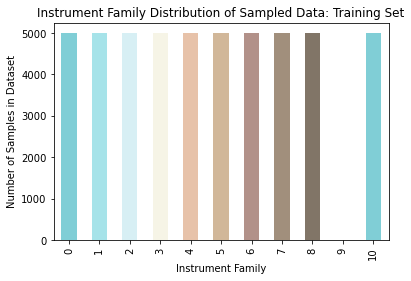

In [22]:
color_palette = ['#80ced6', '#a6e3e9', '#d7eff4', '#f6f4e6', '#e7c2a9', '#d1b799', '#b29189', '#a18f7c', '#817567', '#5a4d46']

#Displaying the instrument distribution
df_train_sample['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot(kind='bar', color=color_palette)
plt.title("Instrument Family Distribution of Sampled Data: Training Set")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [23]:
#save the train file index as list
filenames_train = df_train_sample.index.tolist()

In [24]:
#save the list to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [25]:
#extract the filenames from the validation dataset
df_valid = pd.read_json(path_or_buf='/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/nsynth-split/val/valid-split.json', orient='index')

#save the train file index as list
filenames_valid = df_valid.index.tolist()

#save the list to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/filenames_valid.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

In [26]:
#extract the filenames from the testing dataset
df_test = pd.read_json(path_or_buf='/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/nsynth-split/test/test-split.json', orient='index')

#save the train file index as list
filenames_test = df_test.index.tolist()

#save the list to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/filenames_test.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

In [27]:
def feature_extract(file):
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing their means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    #chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    #chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, contrast]

In [28]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

## Test Set

In [33]:
from tqdm import tqdm

#create dictionary to store all test features
dict_test = {}

#initialize tqdm with the total number of files
progress_bar = tqdm(total=len(filenames_test), desc="Processing files", unit="file")

#loop over every file in the list
for file in filenames_test:
    file_path = test_dir + '/' + file + '.wav'  #specify directory and .wav
    if not os.path.exists(file_path):
        continue  # skip the file if it doesn't exist
    #extract the features
    features = feature_extract(file_path)
    #add dictionary entry
    dict_test[file] = features

    progress_bar.update(1)  # increment the progress bar

progress_bar.close()  # close the progress bar

Processing files:  10%|█          | 30599/305979 [1:34:40<14:12:04,  5.39file/s]


In [34]:
#convert dict to dataframe
features_test = pd.DataFrame.from_dict(dict_test, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'contrast'])

features_test.head()


,harmonic,mfcc,spectro,contrast
string_acoustic_056-047-075,1,"[-507.21985, 41.643745, 19.530516, 13.701504, ...","[0.0011634921, 0.00048329198, 0.013317238, 0.1...","[22.12100605026567, 19.44858290835864, 18.4564..."
flute_synthetic_000-053-025,0,"[-371.63727, 94.36288, -16.497566, 5.6542244, ...","[0.011052982, 0.14965574, 53.01613, 132.53769,...","[32.03135930346598, 23.644326818462478, 26.098..."
organ_electronic_001-060-127,0,"[-393.38504, 87.40554, 35.586105, 25.661533, 1...","[0.00050898484, 0.02010324, 0.06823255, 0.1376...","[26.22808205778025, 33.240869859342894, 33.575..."
keyboard_electronic_002-072-075,1,"[-519.7449, 18.89909, -2.1803966, -1.4630762, ...","[0.043451104, 0.001738623, 0.0011552223, 0.001...","[20.535019643824263, 12.685425096581087, 36.86..."
guitar_acoustic_021-096-100,1,"[-540.65356, 3.7915037, -1.2263352, 1.353811, ...","[0.67560095, 1.4443741, 0.55333304, 0.21381876...","[15.437801357129596, 15.504174364667225, 16.22..."


In [35]:
# Extract MFCCs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(), index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

# Extract Spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(), index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')

# Extract Contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(), index=features_test.index)
contrast_test = contrast_test.add_prefix('contrast_')

# Drop the old columns
features_test = features_test.drop(labels=['mfcc', 'spectro', 'contrast'], axis=1)

# Concatenate
df_features_test = pd.concat([features_test, mfcc_test, spectro_test, contrast_test], axis=1, join='inner')
df_features_test.head()



,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,spectro_125,spectro_126,spectro_127,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6
string_acoustic_056-047-075,1,-507.219849,41.643745,19.530516,13.701504,10.135546,6.175853,2.912810,2.373481,0.585242,...,4.364932e-06,8.207117e-07,1.241046e-08,22.121006,19.448583,18.456434,17.684487,17.591990,16.360521,37.968071
flute_synthetic_000-053-025,0,-371.637268,94.362877,-16.497566,5.654224,24.280115,26.226492,20.402313,7.027387,9.045853,...,3.357834e-07,9.740931e-08,4.592398e-10,32.031359,23.644327,26.098699,22.241589,23.567177,23.099435,47.710176
organ_electronic_001-060-127,0,-393.385040,87.405540,35.586105,25.661533,15.142327,-7.776473,-12.265137,-7.048068,-4.952650,...,3.957775e-08,2.093243e-08,1.671509e-09,26.228082,33.240870,33.575216,33.282782,26.366399,27.471283,37.542970
keyboard_electronic_002-072-075,1,-519.744873,18.899090,-2.180397,-1.463076,-7.363991,-8.445083,-9.944641,-11.849157,-10.626397,...,3.377370e-06,2.522285e-07,1.987249e-09,20.535020,12.685425,36.865925,28.328093,21.645329,18.269941,37.289501
guitar_acoustic_021-096-100,1,-540.653564,3.791504,-1.226335,1.353811,1.360006,0.636633,-1.806472,-0.173970,1.186608,...,3.825701e-07,1.658210e-07,1.156663e-09,15.437801,15.504174,16.227503,15.905432,18.791925,16.983810,19.156708


In [36]:
targets_test = []
for name in df_features_test.index.tolist():
    targets_test.append(instrument_code(name))

df_features_test['targets'] = targets_test

In [37]:
#save the dataframe to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/df_features_test.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)

In [24]:
df_features_test.shape

(410, 150)

## Training Set

In [40]:
from tqdm import tqdm
import time
import os

start_train = time.time()

#create dictionary to store all test features
dict_train = {}

#initialize tqdm with the total number of files
progress_bar = tqdm(total=len(filenames_train), desc="Processing files", unit="file")

#loop over every file in the list
for file in filenames_train:
    file_path = train_dir + '/' + file + '.wav'  #specify directory and .wav
    if not os.path.exists(file_path):
        continue  # skip the file if it doesn't exist
    #extract the features
    features = feature_extract(file_path)
    #add dictionary entry
    dict_train[file] = features
    
    #update the progress bar
    progress_bar.update(1)

progress_bar.close()  # close the progress bar


Processing files:  70%|██████████▌    | 35091/50000 [1:52:27<47:46,  5.20file/s]


In [41]:
#convert dict to dataframe
features_train = pd.DataFrame.from_dict(dict_train, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'contrast'])

features_train.head()

,harmonic,mfcc,spectro,contrast
bass_synthetic_118-102-075,1,"[-884.93396, -2.3203752, -7.598537, 6.66996, -...","[0.00044063426, 0.00060137385, 0.00064295385, ...","[9.479299399324223, 8.787517992549054, 12.1195..."
bass_synthetic_091-037-100,0,"[-220.0127, 109.07345, -42.029823, 62.09751, -...","[0.1819481, 46.34813, 238.5497, 34.72152, 41.9...","[24.463467621350542, 22.673240461884596, 24.14..."
bass_synthetic_049-050-127,1,"[-428.32144, 78.93256, 49.03747, 19.451157, 1....","[0.016784597, 0.01956255, 0.04476818, 0.146556...","[33.949062825454725, 16.94001221390807, 38.501..."
bass_synthetic_024-039-075,0,"[-138.6755, 111.49452, -36.53803, 54.51958, -2...","[0.16255866, 28.896954, 870.7086, 449.51263, 1...","[28.111753887269764, 24.796153935011773, 25.16..."
bass_synthetic_076-068-100,1,"[-376.69418, 63.272846, 26.981892, 44.229336, ...","[2.5896237, 0.07067524, 0.07715517, 0.09184048...","[28.638974235671313, 28.643533908153476, 38.44..."


In [42]:
# Extract MFCCs
mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(), index=features_train.index)
mfcc_train = mfcc_train.add_prefix('mfcc_')

# Extract Spectro
spectro_train = pd.DataFrame(features_train.spectro.values.tolist(), index=features_train.index)
spectro_train = spectro_train.add_prefix('spectro_')

# Extract Contrast
contrast_train = pd.DataFrame(features_train.contrast.values.tolist(), index=features_train.index)
contrast_train = contrast_train.add_prefix('contrast_')

# Drop the old columns
features_train = features_train.drop(labels=['mfcc', 'spectro', 'contrast'], axis=1)

# Concatenate
df_features_train = pd.concat([features_train, mfcc_train, spectro_train, contrast_train], axis=1, join='inner')
df_features_train.head()


,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,spectro_125,spectro_126,spectro_127,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6
bass_synthetic_118-102-075,1,-884.933960,-2.320375,-7.598537,6.669960,-5.757733,-4.570653,3.537684,8.229434,-8.154847,...,1.177349e-04,2.851789e-05,3.621068e-06,9.479299,8.787518,12.119563,13.133300,25.771786,15.772252,38.933736
bass_synthetic_091-037-100,0,-220.012695,109.073448,-42.029823,62.097511,-25.180239,24.453278,-6.118116,0.722401,1.046290,...,1.167327e-03,2.125629e-04,2.631775e-06,24.463468,22.673240,24.142719,24.608647,24.602065,24.604566,54.848149
bass_synthetic_049-050-127,1,-428.321442,78.932564,49.037472,19.451157,1.052137,-5.299679,-4.053771,-0.971190,0.050625,...,6.351597e-08,9.520607e-09,2.131584e-09,33.949063,16.940012,38.501161,36.002089,17.692788,20.552890,35.605601
bass_synthetic_024-039-075,0,-138.675507,111.494522,-36.538029,54.519581,-28.018496,33.449951,-21.018784,15.656427,-11.976345,...,6.847624e-02,1.107244e-02,4.178098e-05,28.111754,24.796154,25.164830,25.219987,24.655611,22.543501,58.148560
bass_synthetic_076-068-100,1,-376.694183,63.272846,26.981892,44.229336,-0.434627,10.206123,-12.221120,-1.409725,-9.253183,...,5.537200e-04,1.236483e-04,3.160769e-08,28.638974,28.643534,38.444684,42.543455,36.476545,30.924845,50.318333


In [43]:
targets_train = []
for name in df_features_train.index.tolist():
    targets_train.append(instrument_code(name))

In [44]:
df_features_train['targets'] = targets_train

In [45]:
#save the dataframe to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/df_features_train.pickle','wb') as f:
    pickle.dump(df_features_train, f)

In [46]:
df_features_train.shape

(35091, 150)

## Validation Set

In [55]:
from tqdm import tqdm
import time
import os

#create dictionary to store all test features
dict_valid = {}

#initialize progress bar
pbar = tqdm(total=len(filenames_valid))

#loop over every file in the list
for file in filenames_valid:
    try:
        #extract the features
        features = feature_extract(valid_dir + '/' + file + '.wav') #specify directory and .wav
        #add dictionary entry
        dict_valid[file] = features
    except FileNotFoundError:
        # Skip missing files
        continue
    finally:
        # update progress bar
        pbar.update(1)

#close progress bar
pbar.close()

end_valid = time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid), end_valid - start_valid))

  0%|                                                | 0/305979 [00:00<?, ?it/s]/var/folders/df/bt6c3x210vg4q9mjm818gv7c0000gn/T/ipykernel_11692/2454132408.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file)
100%|█████████████████████████████████| 305979/305979 [3:10:37<00:00, 26.75it/s]

Time to extract 305979 files is 12144.29119515419 seconds


In [56]:
#convert dict to dataframe
features_valid = pd.DataFrame.from_dict(dict_valid, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'contrast'])

features_valid.head()

,harmonic,mfcc,spectro,contrast
guitar_acoustic_010-066-100,0,"[-439.3734, 59.546818, 2.8950782, -12.039842, ...","[0.0014635242, 0.0026336873, 0.0022025616, 0.0...","[12.373146069245387, 34.62253462234786, 35.319..."
keyboard_electronic_001-063-075,0,"[-486.98077, 61.603725, 6.4476347, 4.8322916, ...","[0.03129459, 0.027230911, 0.03879043, 0.097688...","[16.425554032094084, 29.217522528134296, 32.77..."
bass_synthetic_068-084-050,1,"[-520.6104, 6.5620966, -5.5235143, -7.378478, ...","[0.0013235883, 0.0020167292, 0.0022447398, 0.0...","[14.285085554259364, 14.370813252924794, 15.32..."
guitar_acoustic_015-068-127,1,"[-575.02924, 28.103386, 4.8317046, 1.7395808, ...","[0.008605049, 0.020455431, 0.024745746, 0.0401...","[14.589118821937978, 24.401883413659345, 39.04..."
bass_synthetic_135-071-100,0,"[-457.3785, 22.505526, 7.814209, 2.0482905, -6...","[0.045533884, 0.03689706, 0.029990196, 0.02652...","[18.83257122544787, 13.409335156450316, 48.047..."


In [57]:
# Extract MFCCs
mfcc_valid = pd.DataFrame(features_valid.mfcc.values.tolist(), index=features_valid.index)
mfcc_valid = mfcc_valid.add_prefix('mfcc_')

# Extract Spectro
spectro_valid = pd.DataFrame(features_valid.spectro.values.tolist(), index=features_valid.index)
spectro_valid = spectro_valid.add_prefix('spectro_')

# Extract Contrast
contrast_valid = pd.DataFrame(features_valid.contrast.values.tolist(), index=features_valid.index)
contrast_valid = contrast_valid.add_prefix('contrast_')

# Drop the old columns
features_valid = features_valid.drop(labels=['mfcc', 'spectro', 'contrast'], axis=1)

# Concatenate
df_features_valid = pd.concat([features_valid, mfcc_valid, spectro_valid, contrast_valid], axis=1, join='inner')
df_features_valid.head()


,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,spectro_125,spectro_126,spectro_127,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6
guitar_acoustic_010-066-100,0,-439.373413,59.546818,2.895078,-12.039842,-12.553243,-11.451952,-12.535439,-20.456726,-19.256969,...,7.209504e-07,1.038178e-08,5.382589e-10,12.373146,34.622535,35.319020,37.118663,35.319697,25.386074,38.769826
keyboard_electronic_001-063-075,0,-486.980774,61.603725,6.447635,4.832292,14.117064,1.650681,-6.994359,-1.949207,0.456022,...,8.754932e-08,1.088747e-07,3.141222e-10,16.425554,29.217523,32.770626,30.736964,29.853169,21.863298,44.947590
bass_synthetic_068-084-050,1,-520.610413,6.562097,-5.523514,-7.378478,-6.120591,1.317121,6.615962,8.325761,-0.442400,...,4.309670e-03,3.201773e-03,6.351338e-06,14.285086,14.370813,15.321554,33.932396,22.011258,18.953290,37.915390
guitar_acoustic_015-068-127,1,-575.029236,28.103386,4.831705,1.739581,-9.511461,-9.422133,-14.728680,-13.010304,-13.451746,...,3.889472e-04,3.624799e-05,2.521262e-06,14.589119,24.401883,39.048534,32.863994,20.598248,16.918626,41.026196
bass_synthetic_135-071-100,0,-457.378510,22.505526,7.814209,2.048290,-6.127820,-13.137642,-17.849558,-18.228214,-17.378223,...,1.727788e-04,6.742468e-06,6.351294e-07,18.832571,13.409335,48.047194,31.433009,30.175566,25.718309,47.339010


In [58]:
targets_valid = []
for name in df_features_valid.index.tolist():
    targets_valid.append(instrument_code(name))

df_features_valid['targets'] = targets_valid

In [59]:
df_features_valid.shape

(61195, 150)

In [60]:
#save the dataframe to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/df_features_valid.pickle','wb') as f:
    pickle.dump(df_features_valid, f)

## Cleaning JSON Files

In [61]:
#extract qualities
train_qual = pd.DataFrame(df_train_sample.qualities.values.tolist(), index= df_train_sample.index)


#concatenate
json_train=pd.concat([df_train_sample, train_qual],
                           axis=1, join='inner')

json_train= json_train.drop(labels=['qualities'], axis=1)
json_train.head()

,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,...,0,1,2,3,4,5,6,7,8,9
bass_synthetic_118-102-075,102,219768,synthetic,75,bass_synthetic_118,874,16000,"[fast_decay, percussive]",2,bass_synthetic_118-102-075,...,0,0,0,1,0,0,0,1,0,0
bass_synthetic_091-037-100,37,238128,synthetic,100,bass_synthetic_091,761,16000,"[bright, distortion]",2,bass_synthetic_091-037-100,...,1,0,1,0,0,0,0,0,0,0
bass_synthetic_049-050-127,50,203933,synthetic,127,bass_synthetic_049,530,16000,[],2,bass_synthetic_049-050-127,...,0,0,0,0,0,0,0,0,0,0
bass_synthetic_024-039-075,39,283127,synthetic,75,bass_synthetic_024,335,16000,"[bright, distortion]",2,bass_synthetic_024-039-075,...,1,0,1,0,0,0,0,0,0,0
bass_synthetic_076-068-100,68,283131,synthetic,100,bass_synthetic_076,691,16000,[distortion],2,bass_synthetic_076-068-100,...,0,0,1,0,0,0,0,0,0,0


In [62]:
#save the dataframe to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/json_train.pickle', 'wb') as f:
    pickle.dump(json_train, f)

In [63]:
#extract qualities
test_qual = pd.DataFrame(df_test.qualities.values.tolist(), index= df_test.index)


#concatenate
json_test=pd.concat([df_test, test_qual],
                           axis=1, join='inner')

json_test= json_test.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/json_test.pickle', 'wb') as f:
    pickle.dump(json_test, f)

In [64]:
#extract qualities
valid_qual = pd.DataFrame(df_valid.qualities.values.tolist(), index= df_valid.index)


#concatenate
json_valid=pd.concat([df_valid, valid_qual],
                           axis=1, join='inner')

json_valid= json_valid.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('/Users/abhimanyuwadhwa/Desktop/QMUL/MScProject/dataset-split/json_valid.pickle', 'wb') as f:
    pickle.dump(json_valid, f)